Efficiency Toy
====

Example of the efficiency correction procedure using multiple distributions

In [1]:
# Just some boilerplate code
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from matplotlib import rcParams

rcParams["figure.figsize"] = (10.0, 8.0)

rng = np.random.default_rng()
pdf_domain = (-3, 7)
pdf_range = (0, 1.0)


def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

We have three different distributions - call them WS, RS ("wrong/right sign") and phsp.
We can generate these from the models ("model sample") or via LHCb Monte Carlo ("MC sample").

The MC samples are affected by the efficiency- by comparing the MC sample to the model samples
We can extract the efficiency function $\epsilon(x)$.

We have three models; their PDFs are $\mathcal{A}_{RS}(x)$, $\mathcal{A}_{WS}(x)$ and $\mathcal{A}_{phsp}(x)$.
The corresponding PDFs describing the MC are $\mathcal{A}_{RS}(x)\epsilon(x)$, etc.

The PDF describing the combined model samples is:
$p_{model}(x) = \mathcal{I}_{RS}\mathcal{A}_{RS}(x) + \mathcal{I}_{WS}\mathcal{A}_{WS}(x) + \mathcal{I}_{phsp}\mathcal{A}_{phsp}(x)$; the PDF describing the combined MC samples is this multiplied by $\epsilon(x)$. $\mathcal{I}_i$ are numerical factors that can be found from the relative statistics of the MC samples.

Below is a toy example of the procedure used to find the efficiency.

First we need to generate MC samples:

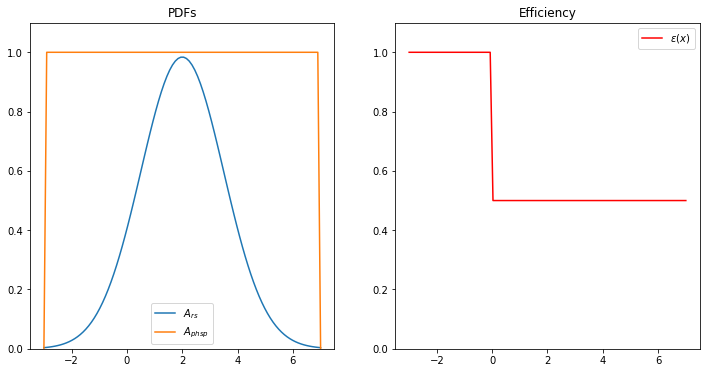

In [32]:
# Model "PDFs" - not normalised (on purpose, since in reality amplitude models are rarely normalised)
def A_rs(x):
    return 3.7 * norm.pdf(x, loc=2.0, scale=1.5)

def A_phsp(x):
    return int(pdf_domain[0] < x < pdf_domain[1])

def e(x):
    if x < 0:
        return 1
    return 0.5

x = np.linspace(*pdf_domain, 100)
fig, ax = plt.subplots(1, 2, figsize=(12.0, 6.0))
ax[0].plot(x, [A_rs(i) for i in x], label=r"$A_{rs}$")
ax[0].plot(x, [A_phsp(i) for i in x], label=r"$A_{phsp}$")
ax[0].set_ylim((0.0, 1.1))
ax[0].legend()
ax[0].set_title("PDFs")

ax[1].plot(x, [e(i) for i in x], label="$\epsilon(x)$", color="r")
ax[1].legend()
ax[1].set_ylim((0.0, 1.1))
ax[1].set_title("Efficiency")

plt.show()


In [33]:
# Generate different numbers of points from each distribution 
mc_rs_sample = sample(20000, lambda x: A_rs(x) * e(x))
mc_phsp_sample = sample(20000, lambda x: A_phsp(x) * e(x))
mc_sample = np.concatenate((mc_rs_sample, mc_phsp_sample))

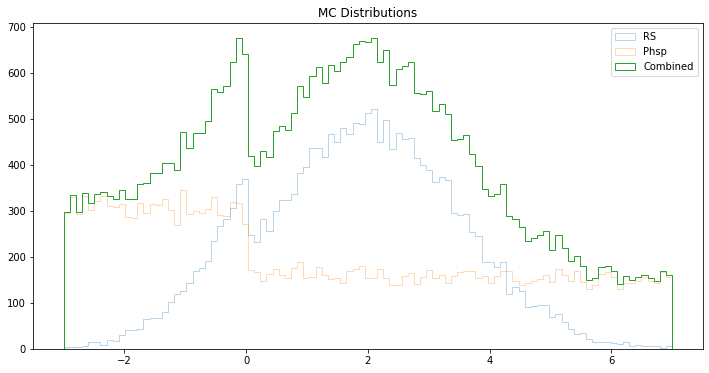

In [34]:
bins = x
kw = {"histtype": "step", "bins": bins}

plt.figure(figsize=(12.0, 6.0))
plt.hist(mc_rs_sample, **kw, alpha=0.3, label="RS")
plt.hist(mc_phsp_sample, **kw, alpha=0.3, label="Phsp")
plt.hist(mc_sample, **kw, label="Combined")
plt.legend()
plt.title("MC Distributions")
plt.show()

Next we need to find the weights $\mathcal{I}_i$ describing the combined model:

In [35]:
I_rs, I_phsp = 0.0, 0.0

for p in mc_rs_sample:
    I_rs += 1 / A_rs(p)
for p in mc_phsp_sample:
    I_phsp += 1 / A_phsp(p)
    
# Scale the weights to something more sensible
scale_factor = I_rs + I_phsp
I_rs /= scale_factor
I_phsp /= scale_factor

We can then construct the model PDF. This, when multiplied by the efficiency, should also describe the MC sample.

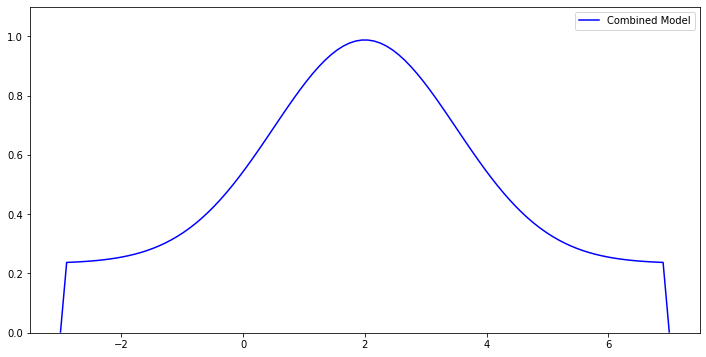

In [36]:
def combined_pdf(x):
    return I_rs * A_rs(x) + I_phsp * A_phsp(x)

model = [combined_pdf(i) for i in x]

plt.figure(figsize=(12.0, 6.0))
plt.plot(x, model, "b", label="Combined Model")
plt.gca().set_ylim((0.0, 1.1))
plt.legend()

plt.show()

It looks like our combined PDF does what we expected.

Now we just need to take a sample from the Model PDF, compare it to our combined MC samples and we should recover the correct efficiency.

In [37]:
# Take a sample from the combined PDF
combined_sample = sample(80000, combined_pdf)

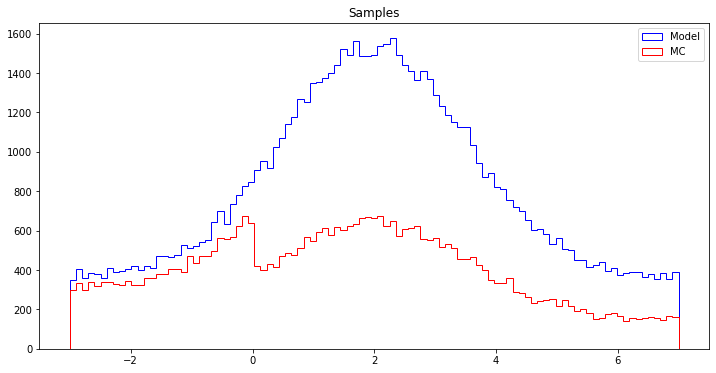

In [38]:
fig = plt.figure(figsize=(12.0, 6.0))

model_hist, _, _ = plt.hist(combined_sample, **kw, label="Model", color="b")
mc_hist, _, _ = plt.hist(mc_sample, **kw, label="MC", color="r")
plt.title("Samples")
plt.legend()

plt.show()

In [43]:
bin_centres = (bins[1:] + bins[:-1]) / 2
hist_ratio = mc_hist / model_hist
ideal_efficiency = [e(x) for x in bin_centres]

# scale the histogram ratio
scale_factor = np.mean(hist_ratio[bin_centres <  0])
hist_ratio /= scale_factor
print(scale_factor)

0.8325381167866422


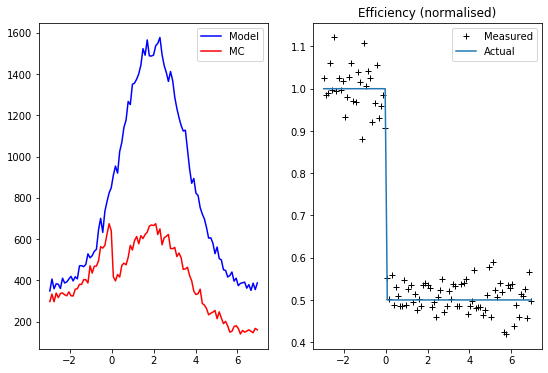

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6))

ax[0].plot(bin_centres, model_hist, "b", label="Model")
ax[0].plot(bin_centres, mc_hist, "r", label="MC")
ax[0].legend()


ax[1].plot(bin_centres, hist_ratio, "k+", label="Measured")
ax[1].plot(bin_centres, ideal_efficiency, label="Actual")
ax[1].set_title("Efficiency (normalised)")
ax[1].legend()
plt.show()